## <span style="color:#ff5f27">🧬 Train Retrieval Model </span>

In this notebook, you will train a retrieval model that will be able to quickly generate a small subset of candidate items from a large collection of items. Your model will be based on the *two-tower architecture*, which embeds queries and candidates (keys) into a shared low-dimensional vector space. Here, a query consists of features of a customer and a transaction (e.g. timestamp of the purchase), whereas a candidate consists of features of a particular item. All queries will have a user ID and all candidates will have an item ID, and the model will be trained such that the embedding of a user will be close to all the embeddings of items the user has previously bought.

After training the model you will save and upload its components to the Hopsworks Model Registry.

Let's go ahead and load the data.

In [4]:
import time

# Start the timer
notebook_start_time = time.time()

## <span style="color:#ff5f27">📝 Imports </span>

In [5]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import StringLookup, Normalization

import tensorflow_recommenders as tfrs

import warnings
warnings.filterwarnings('ignore')

## <span style="color:#ff5f27">🔮 Connect to Hopsworks Feature Store </span>

In [6]:
import hopsworks

project = hopsworks.login(api_key_value = "Dkez37cDPamSnJUf.HDsceFNWsdWX9blAXWtJxcez9tYRKw6eDYN2TQ5AbNjr9lrQKlMLB7nAZ2wgGBQd")

fs = project.get_feature_store()

2025-03-15 21:56:28,715 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-03-15 21:56:28,732 INFO: Initializing external client
2025-03-15 21:56:28,736 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-03-15 21:56:30,117 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1218722


## <span style="color:#ff5f27">🔪 Feature Selection </span>

First, you'll load the feature groups you created in the previous tutorial.

In [7]:
trans_fg = fs.get_feature_group(
    name="transactions",
    version=1,
)
customers_fg = fs.get_feature_group(
    name="customers",
    version=1,
)
articles_fg = fs.get_feature_group(
    name="articles",
    version=1,
)

You'll need to join these three data sources to make the data compatible with out retrieval model. Recall that each row in the `transactions` feature group relates information about which customer bought which item. You'll join this feature group with the `customers` and `articles` feature groups to inject customer and item features into each row.

In [8]:
# Select features for training data
selected_features = trans_fg.select(["customer_id", "article_id", "t_dat", "price", "month_sin", "month_cos"])\
    .join(customers_fg.select(["age", "club_member_status", "age_group"]), on="customer_id", prefix="customers_")\
    .join(articles_fg.select(["garment_group_name", "index_group_name"]), on="article_id", prefix="articles_")

# Uncomment this if you would like to view your selected features
# selected_features.show(5)

## <span style="color:#ff5f27">⚙️ Feature View Creation </span>

In Hopsworks, you write features to feature groups (where the features are stored) and you read features from feature views. A feature view is a logical view over features, stored in feature groups, and a feature view typically contains the features used by a specific model. This way, feature views enable features, stored in different feature groups, to be reused across many different models.

In [9]:
feature_view = fs.get_or_create_feature_view(
    name='retrieval',
    query=selected_features,
    version=1,
)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1218722/fs/1206352/fv/retrieval/version/1


To view and explore data in the feature view you can retrieve batch data using the `get_batch_data()` method.

## <span style="color:#ff5f27">🏋️ Training Dataset </span>


In [10]:
train_df, val_df, test_df, _, _, _ = feature_view.train_validation_test_split(
    validation_size=0.1, 
    test_size=0.1,
    description='Retrieval dataset splits',
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (6.42s) 


You will train your retrieval model with a subset of features.

For the query embedding you will use:
- `customer_id`: ID of the customer.
- `age`: age of the customer at the time of purchase.
- `month_sin`, `month_cos`: time of year the purchase was made.

For the candidate embedding you will use:
- `article_id`: ID of the item.
- `garment_group_name`: type of garment.
- `index_group_name`: menswear/ladieswear etc.

In [11]:
query_features = ["customer_id", "customers_age", "month_sin", "month_cos"]
candidate_features = ["article_id", "articles_garment_group_name", "articles_index_group_name"]

def df_to_ds(df):
    return tf.data.Dataset.from_tensor_slices({col: df[col] for col in df})

BATCH_SIZE = 2048
train_ds = df_to_ds(train_df).batch(BATCH_SIZE).cache().shuffle(BATCH_SIZE*10)
val_ds = df_to_ds(val_df).batch(BATCH_SIZE).cache()

You will need a list of user and item IDs when you initialize your embeddings.

In [12]:
# Retrieve unique customer IDs and article IDs from the training dataset
user_id_list = train_df["customer_id"].unique().tolist()
item_id_list = train_df["article_id"].unique().tolist()

# Retrieve unique garment group names and index group names from the training dataset
garment_group_list = train_df["articles_garment_group_name"].unique().tolist()
index_group_list = train_df["articles_index_group_name"].unique().tolist()

# Print the number of transactions, number of users, number of items, and unique garment group names
print(f"⛳️ Number of transactions: {len(train_df):,}")
print(f"⛳️ Number of users: {len(user_id_list):,}")
print(f"⛳️ Number of items: {len(item_id_list):,}")
print(garment_group_list)

⛳️ Number of transactions: 17,140
⛳️ Number of users: 958
⛳️ Number of items: 11,948
['Under-, Nightwear', 'Trousers', 'Dresses Ladies', 'Blouses', 'Jersey Fancy', 'Accessories', 'Outdoor', 'Swimwear', 'Socks and Tights', 'Dressed', 'Shirts', 'Woven/Jersey/Knitted mix Baby', 'Knitwear', 'Shoes', 'Skirts', 'Trousers Denim', 'Jersey Basic', 'Dresses/Skirts girls', 'Unknown', 'Special Offers', 'Shorts']


## <span style="color:#ff5f27">🏰 Two Tower Model </span>

The two tower model consist of two models:
- Query model: Generates a query representation given user and transaction features.
- Candidate model: Generates an item representation given item features.

**Both models produce embeddings that live in the same embedding space**. You let this space be low-dimensional to prevent overfitting on the training data. (Otherwise, the model might simply memorize previous purchases, which makes it recommend items customers already have bought).

In [13]:
EMB_DIM = 16

You start with creating the query model.

In [14]:
train_df.head(3)

,customer_id,article_id,t_dat,price,month_sin,month_cos,customers_age,customers_club_member_status,customers_age_group,articles_garment_group_name,articles_index_group_name
0,f7048acb8188d98bde3a5c495475a3c86faafe0eede1f2...,670265002,1540252800000,0.013542,-8.660254e-01,0.500000,48.0,ACTIVE,46-55,"Under-, Nightwear",Ladieswear
1,5d34f84e6cbe9ec4706872bb65376097af1e53f0c7dac5...,751471035,1593475200000,0.033881,1.224647e-16,-1.000000,30.0,ACTIVE,26-35,Trousers,Ladieswear
2,baf6dc7ea8575732794751bb80824fe84fd40e6af86193...,719308002,1558137600000,0.059305,5.000000e-01,-0.866025,48.0,ACTIVE,46-55,Dresses Ladies,Divided


In [15]:
class QueryTower(tf.keras.Model):

    def __init__(self):
        super().__init__()

        self.user_embedding = tf.keras.Sequential([
            StringLookup(
                vocabulary=user_id_list,
                mask_token=None
            ),
            tf.keras.layers.Embedding(
                # Add an additional embedding to account for unknown tokens.
                len(user_id_list) + 1,
                EMB_DIM
            )
        ])

        self.normalized_age = Normalization(axis=None)

        self.fnn = tf.keras.Sequential([
            tf.keras.layers.Dense(EMB_DIM, activation="relu"),
            tf.keras.layers.Dense(EMB_DIM)
        ])

    def call(self, inputs):
        concatenated_inputs = tf.concat([
            self.user_embedding(inputs["customer_id"]),
            tf.reshape(self.normalized_age(inputs["customers_age"]), (-1,1)),
            tf.reshape(inputs["month_sin"], (-1,1)),
            tf.reshape(inputs["month_cos"], (-1,1))
        ], axis=1)

        outputs = self.fnn(concatenated_inputs)

        return outputs


query_model = QueryTower()

query_model.normalized_age.adapt(train_ds.map(lambda x : x["customers_age"]))

# Initialize model with inputs.
query_df = train_df[query_features]
query_ds = df_to_ds(query_df).batch(1)
query_model(next(iter(query_ds)))

<tf.Tensor: shape=(1, 16), dtype=float32, numpy=
array([[-0.06828514,  0.26234728, -0.14856434,  0.20797168,  0.11274482,
        -0.21644562, -0.29657784, -0.05429107, -0.20240447,  0.18406554,
         0.00241623, -0.29077494, -0.03622267,  0.18459521, -0.01139493,
        -0.18209326]], dtype=float32)>

The candidate model is very similar to the query model. A difference is that it has two categorical features as input, which you one-hot encode.

In [16]:
class ItemTower(tf.keras.Model):

    def __init__(self):
        super().__init__()

        self.item_embedding = tf.keras.Sequential([
            StringLookup(
                vocabulary=item_id_list,
                mask_token=None
            ),
            tf.keras.layers.Embedding(
                # Add an additional embedding to account for unknown tokens.
                len(item_id_list) + 1,
                EMB_DIM
            )
        ])
        # Converts strings into integer indices (scikit-learn LabelEncoder analog)
        self.garment_group_tokenizer = StringLookup(
            vocabulary=garment_group_list, 
            mask_token=None,
        )
        self.index_group_tokenizer = StringLookup(
            vocabulary=index_group_list, 
            mask_token=None,
        )

        self.fnn = tf.keras.Sequential([
            tf.keras.layers.Dense(EMB_DIM, activation="relu"),
            tf.keras.layers.Dense(EMB_DIM)
        ])

    def call(self, inputs):
        garment_group_embedding = tf.one_hot(
            self.garment_group_tokenizer(inputs["articles_garment_group_name"]),
            len(garment_group_list),
        )

        index_group_embedding = tf.one_hot(
            self.index_group_tokenizer(inputs["articles_index_group_name"]),
            len(index_group_list),
        )

        concatenated_inputs = tf.concat([
            self.item_embedding(inputs["article_id"]),
            garment_group_embedding,
            index_group_embedding,
        ], axis=1)

        outputs = self.fnn(concatenated_inputs)

        return outputs


item_model = ItemTower()

You will evaluate the two tower model using the *top-100 accuracy*. That is, for each transaction in the validation data you will generate the associated query embedding and retrieve the set of the 100 items that are closest to this query in the embedding space. The top-100 accuracy measures how often the item that was actually bought is part of this subset. To evaluate this, you create a dataset of all unique items in the training data.

In [17]:
item_df = train_df[candidate_features]
item_df.drop_duplicates(subset="article_id", inplace=True)
item_ds = df_to_ds(item_df)

With this in place, you can finally create your two tower model.

In [18]:
class TwoTowerModel(tf.keras.Model):
    def __init__(self, query_model, item_model):
        super().__init__()
        self.query_model = query_model
        self.item_model = item_model
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=item_ds.batch(BATCH_SIZE).map(self.item_model)
            )
        )

    def train_step(self, batch) -> tf.Tensor:
        # Set up a gradient tape to record gradients.
        with tf.GradientTape() as tape:

            # Loss computation.
            user_embeddings = self.query_model(batch)
            item_embeddings = self.item_model(batch)
            loss = self.task(
                user_embeddings, 
                item_embeddings,
                compute_metrics=False,
            )

            # Handle regularization losses as well.
            regularization_loss = sum(self.losses)

            total_loss = loss + regularization_loss

        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        metrics = {
            "loss": loss,
            "regularization_loss": regularization_loss,
            "total_loss": total_loss
        }

        return metrics

    def test_step(self, batch) -> tf.Tensor:
        # Loss computation.
        user_embeddings = self.query_model(batch)
        item_embeddings = self.item_model(batch)

        loss = self.task(
            user_embeddings, 
            item_embeddings,
            compute_metrics=False,
        )

        # Handle regularization losses as well.
        regularization_loss = sum(self.losses)

        total_loss = loss + regularization_loss

        metrics = {metric.name: metric.result() for metric in self.metrics}
        metrics["loss"] = loss
        metrics["regularization_loss"] = regularization_loss
        metrics["total_loss"] = total_loss

        return metrics

### <span style="color:#ff5f27">🏃🏻‍♂️ Model Training </span>

You'll train our model using the AdamW optimizer, which applies weight regularization during training.

In [19]:
# Create a TwoTowerModel with the specified query_model and item_model
model = TwoTowerModel(query_model, item_model)

# Define an optimizer using AdamW with a learning rate of 0.01
optimizer = tf.keras.optimizers.AdamW(weight_decay=0.001, learning_rate=0.01)

# Compile the model using the specified optimizer
model.compile(optimizer=optimizer)

In [20]:
history = model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=5,
)

Epoch 1/5
9/9 [==============================] - 6s 191ms/step - loss: 13463.4265 - regularization_loss: 0.0000e+00 - total_loss: 13463.4265 - val_factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - val_loss: 421.6490 - val_regularization_loss: 0.0000e+00 - val_total_loss: 421.6490
Epoch 2/5
9/9 [==============================] - 1s 105ms/step - loss: 14258.4806 - regularization_loss: 0.0000e+00 - total_loss: 14258.4806 - val_factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - va

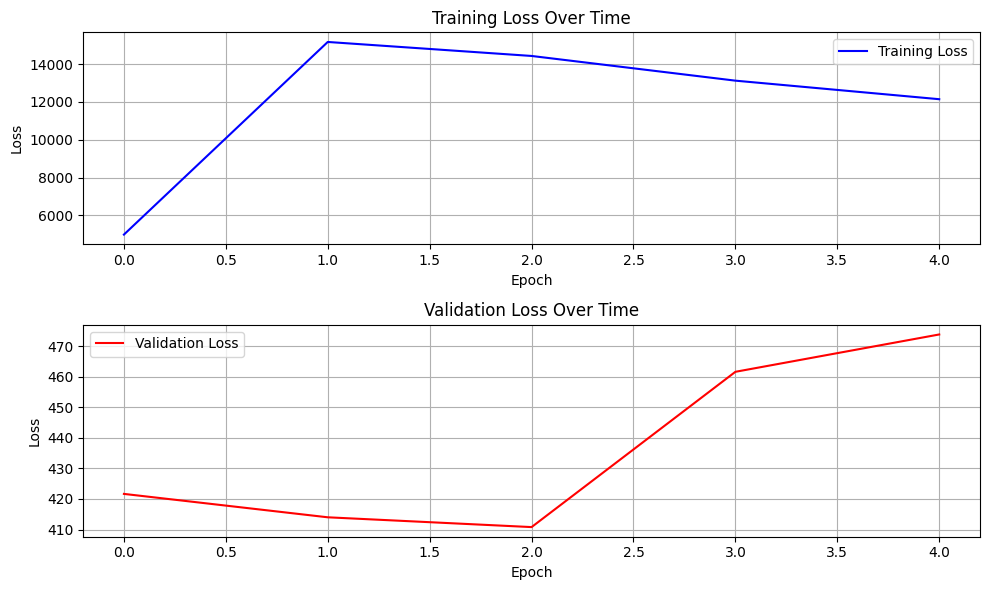

In [21]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

# Training loss subplot
ax1.plot(history.history["loss"], label="Training Loss", color="blue")
ax1.set_title("Training Loss Over Time")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)

# Validation loss subplot
ax2.plot(history.history["val_loss"], label="Validation Loss", color="red")
ax2.set_title("Validation Loss Over Time")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
# plt.show() # Uncomment to show the plot

## <span style="color:#ff5f27">🗄️ Upload Model to Model Registry </span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

Let's connect to the model registry using the [HSML library](https://docs.hopsworks.ai/machine-learning-api/latest) from Hopsworks.

In [22]:
mr = project.get_model_registry()

In [23]:
class QueryModelModule(tf.Module):
    def __init__(self, query_model):
        self.query_model = query_model

    @tf.function()
    def compute_emb(self, instances):
        query_emb = self.query_model(instances)
        return {
            "customer_id": instances["customer_id"],
            "month_sin": instances["month_sin"],
            "month_cos": instances["month_cos"],
            "query_emb": query_emb,
        }

# wrap query_model:   query_model -> query_model_module
query_model = QueryModelModule(model.query_model)

In [24]:
# Define the input specifications for the instances
instances_spec = {
    'customer_id': tf.TensorSpec(shape=(None,), dtype=tf.string, name='customer_id'),       # Specification for customer IDs
    'month_sin': tf.TensorSpec(shape=(None,), dtype=tf.float64, name='month_sin'),          # Specification for sine of month
    'month_cos': tf.TensorSpec(shape=(None,), dtype=tf.float64, name='month_cos'),          # Specification for cosine of month
    'customers_age': tf.TensorSpec(shape=(None,), dtype=tf.float64, name='customers_age'),  # Specification for age
}

# Get the concrete function for the query_model's compute_emb function using the specified input signatures
signatures = query_model.compute_emb.get_concrete_function(instances_spec)

# Save the query_model along with the concrete function signatures
tf.saved_model.save(
    query_model,           # The model to save
    "query_model",         # Path to save the model
    signatures=signatures, # Concrete function signatures to include
)

2025-03-15 21:57:08,724 INFO: Function `compute_emb` contains input name(s) table_handle, 3202, resource with unsupported characters which will be renamed to query_tower_sequential_string_lookup_none_lookup_lookuptablefindv2_table_handle, query_tower_sequential_embedding_embedding_lookup_3202, query_tower_sequential_1_dense_1_biasadd_readvariableop_resource in the SavedModel.
INFO:tensorflow:Assets written to: query_model\assets
2025-03-15 21:57:10,806 INFO: Assets written to: query_model\assets


First, you need to save our models locally.

In [25]:
tf.saved_model.save(
    model.item_model,    # The model to save
    "candidate_model",   # Path to save the model
)

INFO:tensorflow:Assets written to: candidate_model\assets
2025-03-15 21:57:14,849 INFO: Assets written to: candidate_model\assets


In [26]:
# Sample a query example from the query DataFrame
query_example = query_df.sample().to_dict("records")

# Create a tensorflow model for the query_model in the Model Registry 
mr_query_model = mr.tensorflow.create_model(
    name="query_model",                                           # Name of the model
    version=1,
    description="Model that generates query embeddings from user and transaction features",  # Description of the model
    input_example=query_example,                                  # Example input for the model
    feature_view=feature_view,
)

# Save the query_model to the Model Registry
mr_query_model.save("query_model")                                # Path to save the model

Uploading: 100.000%|██████████| 56/56 elapsed<00:02 remaining<00:001<00:04,  1.20it/s]
Uploading: 100.000%|██████████| 189668/189668 elapsed<00:02 remaining<00:00  1.20it/s]
Uploading: 100.000%|██████████| 69188/69188 elapsed<00:02 remaining<00:004,  1.20it/s]
Uploading: 100.000%|██████████| 573/573 elapsed<00:02 remaining<00:0000:04,  1.20it/s]
Uploading: 100.000%|██████████| 162/162 elapsed<00:02 remaining<00:00<00:26,  6.56s/it]
Model export complete: 100%|██████████| 6/6 [00:19<00:00,  3.30s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/1218722/models/query_model/1


Model(name: 'query_model', version: 1)

Here you have also saved an input example from the training data, which can be helpful for test purposes.

Let's repeat the process with the candidate model.

In [27]:
# Sample a candidate example from the item DataFrame
candidate_example = item_df.sample().to_dict("records")

# Create a tensorflow model for the candidate_model in the Model Registry
mr_candidate_model = mr.tensorflow.create_model(
    name="candidate_model",
    version=1,
    description="Model that generates candidate embeddings from item features",
    input_example=candidate_example,
    feature_view=feature_view,
)

# Save the candidate_model to the Model Registry
mr_candidate_model.save("candidate_model")  # Path to save the model

Uploading: 100.000%|██████████| 57/57 elapsed<00:01 remaining<00:001<00:03,  1.28it/s]
Uploading: 100.000%|██████████| 328907/328907 elapsed<00:01 remaining<00:00  1.28it/s]
Uploading: 100.000%|██████████| 773882/773882 elapsed<00:02 remaining<00:00  1.28it/s]
Uploading: 100.000%|██████████| 423/423 elapsed<00:02 remaining<00:0000:03,  1.28it/s]
Uploading: 100.000%|██████████| 111/111 elapsed<00:01 remaining<00:00<00:25,  6.43s/it]
Model export complete: 100%|██████████| 6/6 [00:19<00:00,  3.22s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/1218722/models/candidate_model/1


Model(name: 'candidate_model', version: 1)

---

In [28]:
# End the timer
notebook_end_time = time.time()

# Calculate and print the execution time
notebook_execution_time = notebook_end_time - notebook_start_time
print(f"⌛️ Notebook Execution time: {notebook_execution_time:.2f} seconds")

⌛️ Notebook Execution time: 87.39 seconds


---
## <span style="color:#ff5f27">⏩️ Next Steps </span>

Retrieving the top-k closest candidate embeddings in a brute-force way (computing the distances between the query embedding and all candidate embeddings) is too expensive in a practical setting. In the next notebook, you will compute embeddings and create a feature view which will allow you to retrieve candidates with very low latency.